In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import datetime as dt
plt.rcParams["figure.figsize"] = (18, 6)

In [2]:
ba_beers = pd.read_csv('generated/new_ba_beers.csv')
ba_breweries = pd.read_csv('generated/new_ba_breweries.csv')
ba_users = pd.read_csv('generated/new_ba_users.csv')
ba_reviews = pd.read_parquet('generated/new_ba_reviews.parquet')

rb_beers = pd.read_csv('generated/new_rb_beers.csv')
rb_breweries = pd.read_csv('generated/new_rb_breweries.csv')
rb_users = pd.read_csv('generated/new_rb_users.csv')
rb_reviews = pd.read_parquet('generated/new_rb_reviews.parquet')

# Task - User activity : What can we say about the activity of reviewers

## Group reviews per user

In [3]:
ba_users['user_id'] = ba_users['user_id'].astype(str)
rb_users['user_id'] = rb_users['user_id'].astype(str)
ba_reviews['user_id'] = ba_reviews['user_id'].astype(str)
rb_reviews['user_id'] = rb_reviews['user_id'].astype(str)

#ba_users = ba_users.set_index('user_id')
#rb_users = rb_users.set_index('user_id')

ba_reviews_per_user = ba_reviews.groupby('user_id')
rb_reviews_per_user = rb_reviews.groupby('user_id')

In [4]:
ba_unique_users = ba_reviews['user_id'].unique()
ba_users_from_reviews = pd.DataFrame(ba_unique_users, columns=['user_id'])

ba_users_from_reviews['platform'] = 'BeerAdvocate'

ba_users_from_reviews = ba_users_from_reviews.merge(ba_users[['user_id','joined']], on='user_id', how='left')
ba_users_from_reviews = ba_users_from_reviews.loc[~ba_users_from_reviews.user_id.duplicated()]
ba_users_from_reviews.set_index('user_id', inplace=True)
ba_users_from_reviews['joined'] = pd.to_datetime(ba_users_from_reviews['joined'], dayfirst=True)

ba_users_from_reviews.head()

,platform,joined
user_id,,
smanson56.782386,BeerAdvocate,2014-02-15
oline73.371504,BeerAdvocate,2009-09-18
davolebomb.207412,BeerAdvocate,2008-03-29
urbancaver.392863,BeerAdvocate,2009-11-13
beveritt.73492,BeerAdvocate,2006-04-06


In [5]:
rb_unique_users = rb_reviews['user_id'].unique()
rb_users_from_reviews = pd.DataFrame(rb_unique_users, columns=['user_id'])

rb_users_from_reviews['platform'] = 'RateBeer'

rb_users_from_reviews = rb_users_from_reviews.merge(rb_users[['user_id','joined']], on='user_id', how='left')
rb_users_from_reviews = rb_users_from_reviews.loc[~rb_users_from_reviews.user_id.duplicated()]
rb_users_from_reviews.set_index('user_id', inplace=True)
rb_users_from_reviews['joined'] = pd.to_datetime(rb_users_from_reviews['joined'], dayfirst=True)

rb_users_from_reviews.head()

,platform,joined
user_id,,
175852,RateBeer,2012-05-20
442761,RateBeer,2017-01-10
288889,RateBeer,2013-11-16
250510,RateBeer,2013-03-22
122778,RateBeer,2011-02-02


In [6]:
# 1. total nb of reviews
ba_users_from_reviews['total_reviews'] = ba_reviews_per_user['beer_id'].count()
ba_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews
user_id,,,
--dom--.709199,BeerAdvocate,2012-12-22,16
--weezl--.789708,BeerAdvocate,2014-03-21,1
-rick.912339,BeerAdvocate,2014-12-22,36
-steve-.781156,BeerAdvocate,2014-02-09,6
-wizard-.1097150,BeerAdvocate,2016-01-19,1


In [7]:
# 1. total nb of reviews
rb_users_from_reviews['total_reviews'] = rb_reviews_per_user['beer_id'].count()
rb_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews
user_id,,,
10,RateBeer,2000-04-12,5
100007,RateBeer,2010-01-12,73
100011,RateBeer,2010-01-12,46
100012,RateBeer,2010-01-12,30
100021,RateBeer,2010-01-12,1


In [8]:
# 2. time since registration (until last activity recorded)
ba_users_from_reviews['last_review'] = ba_users_from_reviews['joined'].max()
ba_users_from_reviews['usage_duration'] = (ba_users_from_reviews['last_review'] - ba_users_from_reviews['joined']).dt.days
ba_users_from_reviews.drop(columns='last_review', inplace=True)
ba_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews,usage_duration
user_id,,,,
--dom--.709199,BeerAdvocate,2012-12-22,16,1682.0
--weezl--.789708,BeerAdvocate,2014-03-21,1,1228.0
-rick.912339,BeerAdvocate,2014-12-22,36,952.0
-steve-.781156,BeerAdvocate,2014-02-09,6,1268.0
-wizard-.1097150,BeerAdvocate,2016-01-19,1,559.0


In [9]:
# 2. time since registration (until last activity recorded)
rb_users_from_reviews['last_review'] = rb_users_from_reviews['joined'].max()
rb_users_from_reviews['usage_duration'] = (rb_users_from_reviews['last_review'] - rb_users_from_reviews['joined']).dt.days
rb_users_from_reviews.drop(columns='last_review', inplace=True)
rb_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews,usage_duration
user_id,,,,
10,RateBeer,2000-04-12,5,6318.0
100007,RateBeer,2010-01-12,73,2756.0
100011,RateBeer,2010-01-12,46,2756.0
100012,RateBeer,2010-01-12,30,2756.0
100021,RateBeer,2010-01-12,1,2756.0


In [10]:
# 3. style diversity
ba_users_from_reviews['style_diversity'] = ba_reviews_per_user['style'].nunique()
ba_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews,usage_duration,style_diversity
user_id,,,,,
--dom--.709199,BeerAdvocate,2012-12-22,16,1682.0,10
--weezl--.789708,BeerAdvocate,2014-03-21,1,1228.0,1
-rick.912339,BeerAdvocate,2014-12-22,36,952.0,18
-steve-.781156,BeerAdvocate,2014-02-09,6,1268.0,6
-wizard-.1097150,BeerAdvocate,2016-01-19,1,559.0,1


In [11]:
# 3. style diversity
rb_users_from_reviews['style_diversity'] = rb_reviews_per_user['style'].nunique()
rb_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews,usage_duration,style_diversity
user_id,,,,,
10,RateBeer,2000-04-12,5,6318.0,4
100007,RateBeer,2010-01-12,73,2756.0,32
100011,RateBeer,2010-01-12,46,2756.0,24
100012,RateBeer,2010-01-12,30,2756.0,20
100021,RateBeer,2010-01-12,1,2756.0,1


In [12]:
# 4. style predilection
ba_style_count = ba_reviews_per_user["style"].value_counts().groupby('user_id')
ba_users_from_reviews['predilection_ratio'] = (ba_style_count.max()/ba_users_from_reviews['total_reviews'])
ba_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews,usage_duration,style_diversity,predilection_ratio
user_id,,,,,,
--dom--.709199,BeerAdvocate,2012-12-22,16,1682.0,10,0.187500
--weezl--.789708,BeerAdvocate,2014-03-21,1,1228.0,1,1.000000
-rick.912339,BeerAdvocate,2014-12-22,36,952.0,18,0.277778
-steve-.781156,BeerAdvocate,2014-02-09,6,1268.0,6,0.166667
-wizard-.1097150,BeerAdvocate,2016-01-19,1,559.0,1,1.000000


In [13]:
# 4. style predilection
rb_style_count = rb_reviews_per_user["style"].value_counts().groupby('user_id')
rb_users_from_reviews['predilection_ratio'] = (rb_style_count.max()/rb_users_from_reviews['total_reviews'])
rb_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews,usage_duration,style_diversity,predilection_ratio
user_id,,,,,,
10,RateBeer,2000-04-12,5,6318.0,4,0.400000
100007,RateBeer,2010-01-12,73,2756.0,32,0.150685
100011,RateBeer,2010-01-12,46,2756.0,24,0.195652
100012,RateBeer,2010-01-12,30,2756.0,20,0.133333
100021,RateBeer,2010-01-12,1,2756.0,1,1.000000


In [14]:
# 5. consistency
ba_reviews_sorted = ba_reviews[['user_id','date']].copy()
ba_reviews_sorted.set_index('user_id',inplace=True)
ba_reviews_sorted['date'] = pd.to_datetime(ba_reviews_sorted['date'], dayfirst=True)
ba_reviews_sorted.sort_values('date', inplace=True)

time_spacings = ba_reviews_sorted.groupby('user_id')['date'].apply(lambda x : x.diff().dt.days).dropna()
ba_users_from_reviews['mean_time_spacing'] = (
    time_spacings.groupby('user_id').mean()
)
ba_users_from_reviews['std_time_spacing'] = (
    time_spacings.groupby('user_id').std()
)

ba_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews,usage_duration,style_diversity,predilection_ratio,mean_time_spacing,std_time_spacing
user_id,,,,,,,,
--dom--.709199,BeerAdvocate,2012-12-22,16,1682.0,10,0.187500,82.800000,174.050978
--weezl--.789708,BeerAdvocate,2014-03-21,1,1228.0,1,1.000000,NaN,NaN
-rick.912339,BeerAdvocate,2014-12-22,36,952.0,18,0.277778,13.571429,18.517537
-steve-.781156,BeerAdvocate,2014-02-09,6,1268.0,6,0.166667,171.000000,321.732808
-wizard-.1097150,BeerAdvocate,2016-01-19,1,559.0,1,1.000000,NaN,NaN


In [15]:
# 5. consistency
rb_reviews_sorted = rb_reviews[['user_id','date']].copy()
rb_reviews_sorted.set_index('user_id',inplace=True)
rb_reviews_sorted['date'] = pd.to_datetime(rb_reviews_sorted['date'], dayfirst=True)
rb_reviews_sorted.sort_values('date', inplace=True)

time_spacings = rb_reviews_sorted.groupby('user_id')['date'].apply(lambda x : x.diff().dt.days).dropna()
rb_users_from_reviews['mean_time_spacing'] = (
    time_spacings.groupby('user_id').mean()
)
rb_users_from_reviews['std_time_spacing'] = (
    time_spacings.groupby('user_id').std()
)

rb_users_from_reviews.sort_values('user_id').head()

,platform,joined,total_reviews,usage_duration,style_diversity,predilection_ratio,mean_time_spacing,std_time_spacing
user_id,,,,,,,,
10,RateBeer,2000-04-12,5,6318.0,4,0.400000,19.250000,21.468970
100007,RateBeer,2010-01-12,73,2756.0,32,0.150685,31.930556,83.542235
100011,RateBeer,2010-01-12,46,2756.0,24,0.195652,16.044444,71.228810
100012,RateBeer,2010-01-12,30,2756.0,20,0.133333,63.103448,233.109316
100021,RateBeer,2010-01-12,1,2756.0,1,1.000000,NaN,NaN


## Features definition
1) total number of reviews
2) time since registration
3) diversity of beer styles/types
4) predilection toward a beer style/type
5)  consistency (engagement habits) : frequency mean + std

### BeerAdvocate features

### RateBeer features

In [16]:
ba_features = ba_users_from_reviews.drop(columns=['joined'])
rb_features = rb_users_from_reviews.drop(columns=['joined'])

features = pd.concat([ba_features, rb_features])
features.sample(15)

,platform,total_reviews,usage_duration,style_diversity,predilection_ratio,mean_time_spacing,std_time_spacing
user_id,,,,,,,
271452,RateBeer,16,1464.0,12,0.250000,95.933333,204.662254
72744,RateBeer,1,3406.0,1,1.000000,NaN,NaN
358105,RateBeer,4,897.0,1,1.000000,0.000000,0.000000
11171,RateBeer,1,4879.0,1,1.000000,NaN,NaN
71075,RateBeer,8,3432.0,7,0.250000,194.285714,323.146362
210758,RateBeer,3,1813.0,3,0.333333,0.000000,0.000000
150139,RateBeer,4,2031.0,4,0.250000,14.000000,18.520259
285785,RateBeer,6,1373.0,6,0.166667,31.400000,24.785076
rwilling.637284,BeerAdvocate,1,2087.0,1,1.000000,NaN,NaN


## Data preprocessing

In [17]:
nan_counts = ba_users_from_reviews.isna().sum()
print(f"NaN values in BeerAdvocate features : \n{nan_counts}\n")
nan_counts = rb_users_from_reviews.isna().sum()
print(f"NaN values in RateBeer features : \n{nan_counts}\n")

NaN values in BeerAdvocate features : 
platform                  0
joined                  787
total_reviews             0
usage_duration          787
style_diversity           0
predilection_ratio        0
mean_time_spacing     12842
std_time_spacing      17199
dtype: int64

NaN values in RateBeer features : 
platform                  0
joined                   33
total_reviews             0
usage_duration           33
style_diversity           0
predilection_ratio        0
mean_time_spacing     28099
std_time_spacing      37321
dtype: int64



In [18]:
# Count NaN values in each column
nan_counts = features.isna().sum()

# Display the counts
print(nan_counts)
print(len(features))

# well shit 40% on écrit une seule review et 10% on écrit 2 reviews.

platform                  0
total_reviews             0
usage_duration          820
style_diversity           0
predilection_ratio        0
mean_time_spacing     40941
std_time_spacing      54520
dtype: int64
101925


In [19]:
features_cleaned = features.drop(columns='platform').copy()
features_cleaned.dropna(inplace=True)

In [20]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_cleaned)
features_scaled = pd.DataFrame(features_scaled, columns=features_cleaned.columns, index=features_cleaned.index)

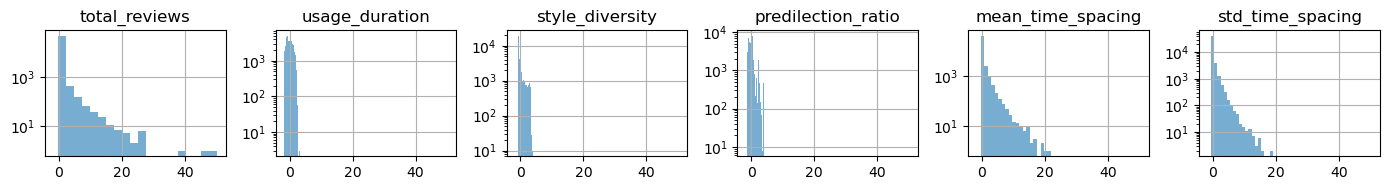

In [36]:
columns = features_scaled.columns

fig, axs = plt.subplots(1, len(columns), figsize=(14,2), sharex=True)

for column_idx in range(0, len(columns)):
    features_scaled[columns[column_idx]].hist(bins=20, ax=axs[column_idx], alpha=0.6)
    axs[column_idx].set_title(columns[column_idx])
    axs[column_idx].set_yscale('log') 
    
plt.tight_layout()

## Dimensionality reduction (PCA)

In [21]:
pca = PCA(n_components=0.95)  # Retain 95% of variance
PCs = pca.fit_transform(features_scaled)
features_reduced = pd.DataFrame(PCs, index=features_scaled.index, columns=[f"PC{i+1}" for i in range(PCs.shape[1])])
print(f"Explained variance by components: {pca.explained_variance_ratio_}\n")
print(f"Unexplained variance: {1-pca.explained_variance_ratio_.sum()}")

Explained variance by components: [0.35619748 0.2848789  0.14737957 0.13739275 0.05669906]

Unexplained variance: 0.017452243279399426


## Number of clusters (silhouette score + elbow method)

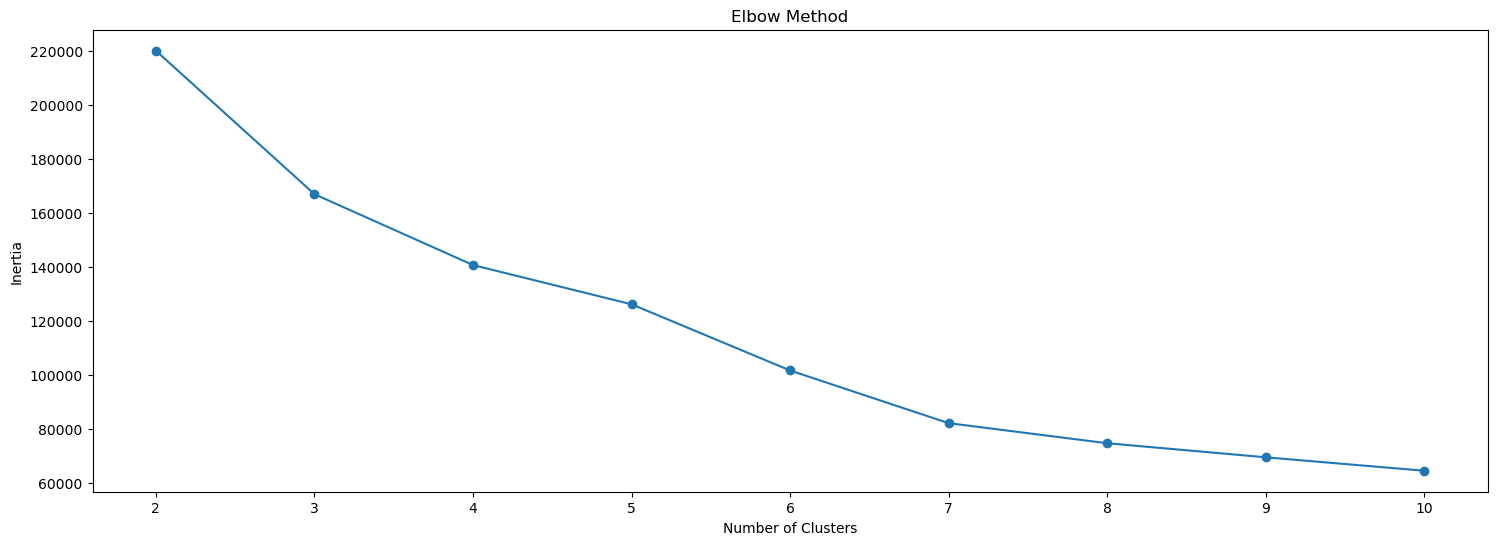

Silhouette Score for 2 clusters: 0.34187060699443583
Silhouette Score for 3 clusters: 0.38835199318848174
Silhouette Score for 4 clusters: 0.28876277221875085
Silhouette Score for 5 clusters: 0.29789220128560684
Silhouette Score for 6 clusters: 0.3386608097573972
Silhouette Score for 7 clusters: 0.33170910036680357
Silhouette Score for 8 clusters: 0.334195708347029
Silhouette Score for 9 clusters: 0.3223855820742651
Silhouette Score for 10 clusters: 0.26824751026535637


In [22]:
# Elbow Method
inertia = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_reduced)
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Silhouette Score
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_reduced)
    score = silhouette_score(features_reduced, labels)
    print(f"Silhouette Score for {k} clusters: {score}")



In [23]:
n_clusters = 3

## Clustering

In [24]:
# Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_reduced)

cluster_labels_series = pd.Series(cluster_labels, index=features_reduced.index, name='cluster')
if 'cluster' not in features.columns:
    features = features.join(cluster_labels_series, how='left')
features.head(20)

,platform,total_reviews,usage_duration,style_diversity,predilection_ratio,mean_time_spacing,std_time_spacing,cluster
user_id,,,,,,,,
smanson56.782386,BeerAdvocate,42,1262.0,18,0.285714,14.853659,37.893641,1.0
oline73.371504,BeerAdvocate,413,2873.0,65,0.079903,2.446602,6.613380,0.0
davolebomb.207412,BeerAdvocate,513,3411.0,81,0.070175,6.111328,16.765369,0.0
urbancaver.392863,BeerAdvocate,269,2817.0,59,0.118959,3.917910,12.320349,0.0
beveritt.73492,BeerAdvocate,161,4134.0,57,0.049689,12.337500,20.755203,0.0
wagenvolks.40929,BeerAdvocate,435,4329.0,76,0.087356,5.751152,10.051728,0.0
rodmanfor3.843710,BeerAdvocate,85,1085.0,27,0.223529,11.369048,16.159431,1.0
hookstrat.59986,BeerAdvocate,2,4215.0,2,0.500000,2695.000000,NaN,NaN
shanepb.500016,BeerAdvocate,107,2520.0,37,0.130841,17.575472,45.306564,0.0


## Evaluation and Visualization

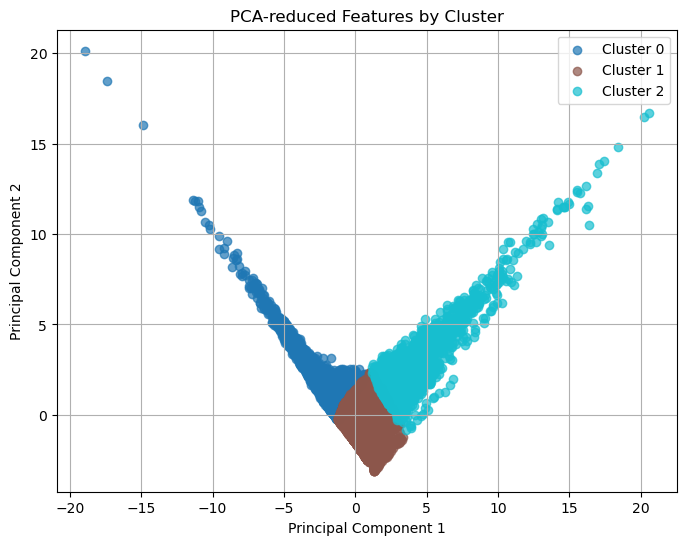

In [64]:
cluster_features_reduced = features_reduced.copy()
if 'cluster' not in cluster_features_reduced.columns:
    cluster_features_reduced = cluster_features_reduced.join(cluster_labels_series, how='left')

colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(8, 6))
for cluster_id in range(n_clusters):
    cluster_points = cluster_features_reduced[cluster_features_reduced['cluster'] == cluster_id]
    plt.scatter(
        cluster_points.iloc[:, 0], 
        cluster_points.iloc[:, 1], 
        alpha=0.7, 
        color=colors[cluster_id], 
        label=f"Cluster {cluster_id}"
    )

# Adding labels, legend, and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA-reduced Features by Cluster")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [25]:
print(f"Inertia: {kmeans.inertia_:.2f}")

#from sklearn.metrics import davies_bouldin_score

#db_score = davies_bouldin_score(rb_features_reduced, rb_features['cluster'].dropna().astype(int))
#print(f"Davies-Bouldin Index: {db_score:.3f}")

Inertia: 167043.63


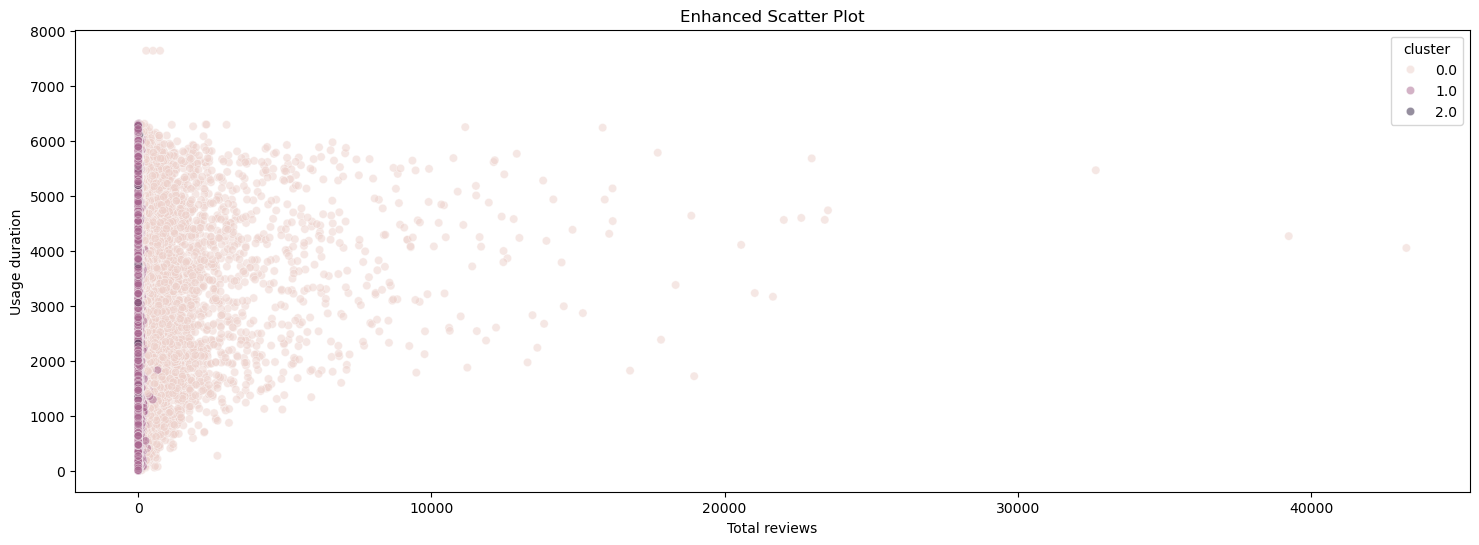

In [26]:
# Scatter plot using seaborn
sns.scatterplot(data=features, x='total_reviews', y='usage_duration', hue='cluster', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Total reviews')
plt.ylabel('Usage duration')
plt.title('Enhanced Scatter Plot')
plt.show()

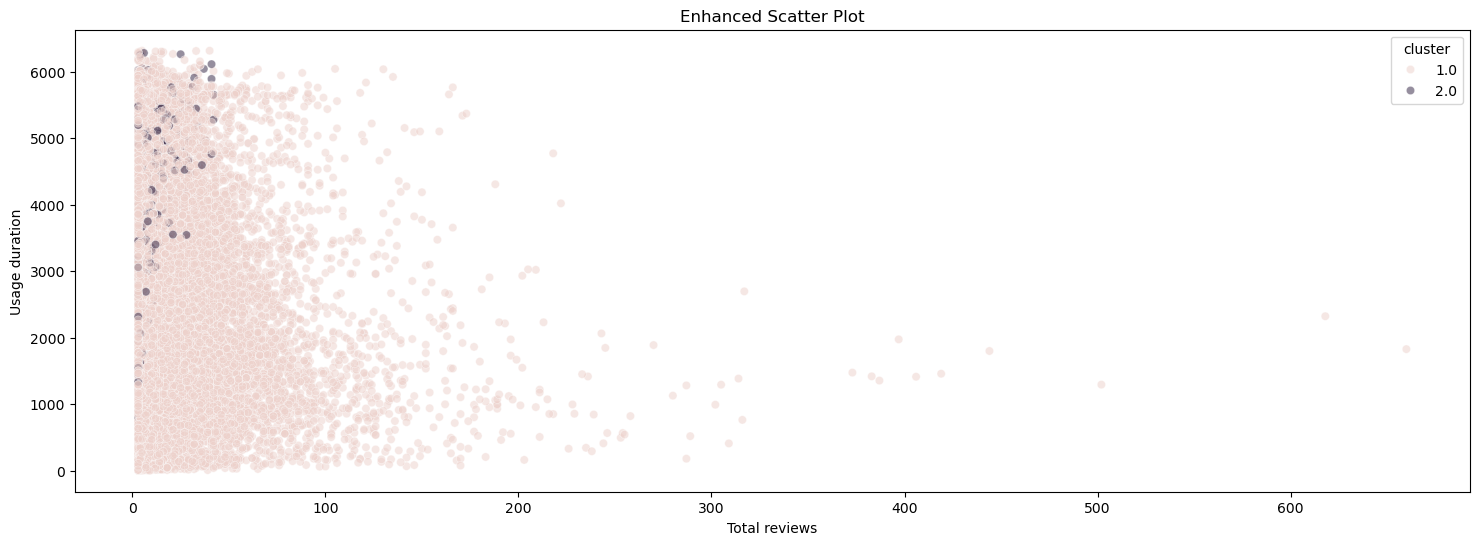

In [50]:
# Scatter plot using seaborn
sns.scatterplot(data=features[features['cluster']!=0], x='total_reviews', y='usage_duration', hue='cluster', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Total reviews')
plt.ylabel('Usage duration')
plt.title('Enhanced Scatter Plot')
plt.show()

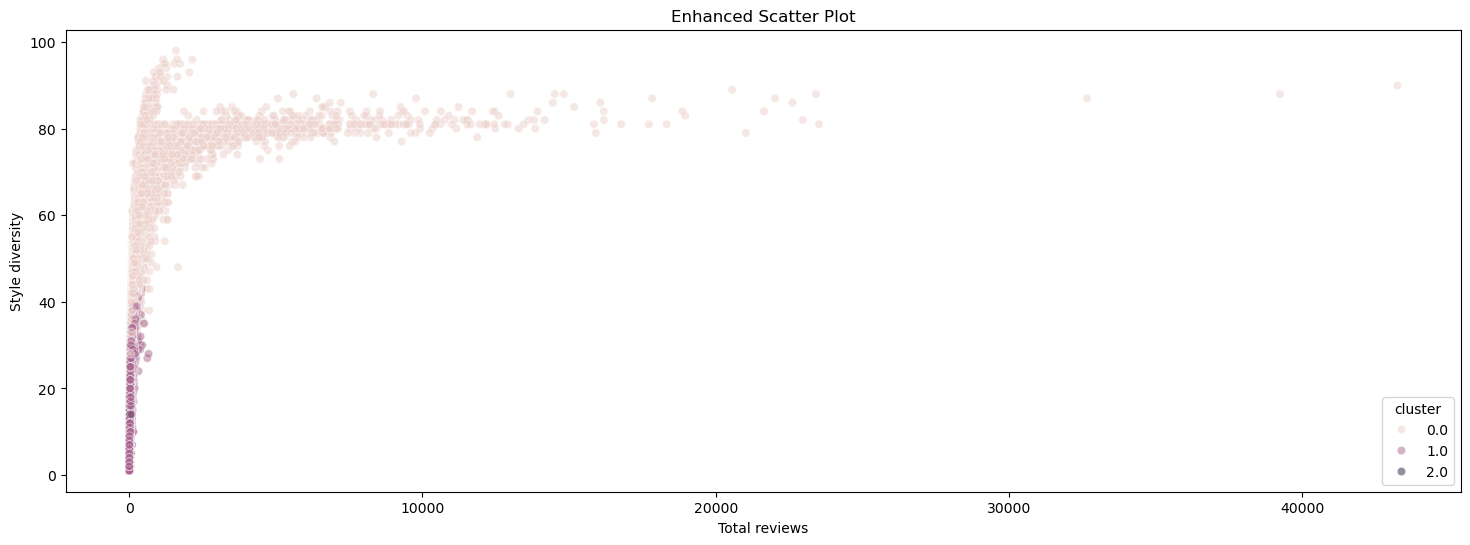

In [27]:
# Scatter plot using seaborn
sns.scatterplot(data=features, x='total_reviews', y='style_diversity', hue='cluster', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Total reviews')
plt.ylabel('Style diversity')
plt.title('Enhanced Scatter Plot')
plt.show()

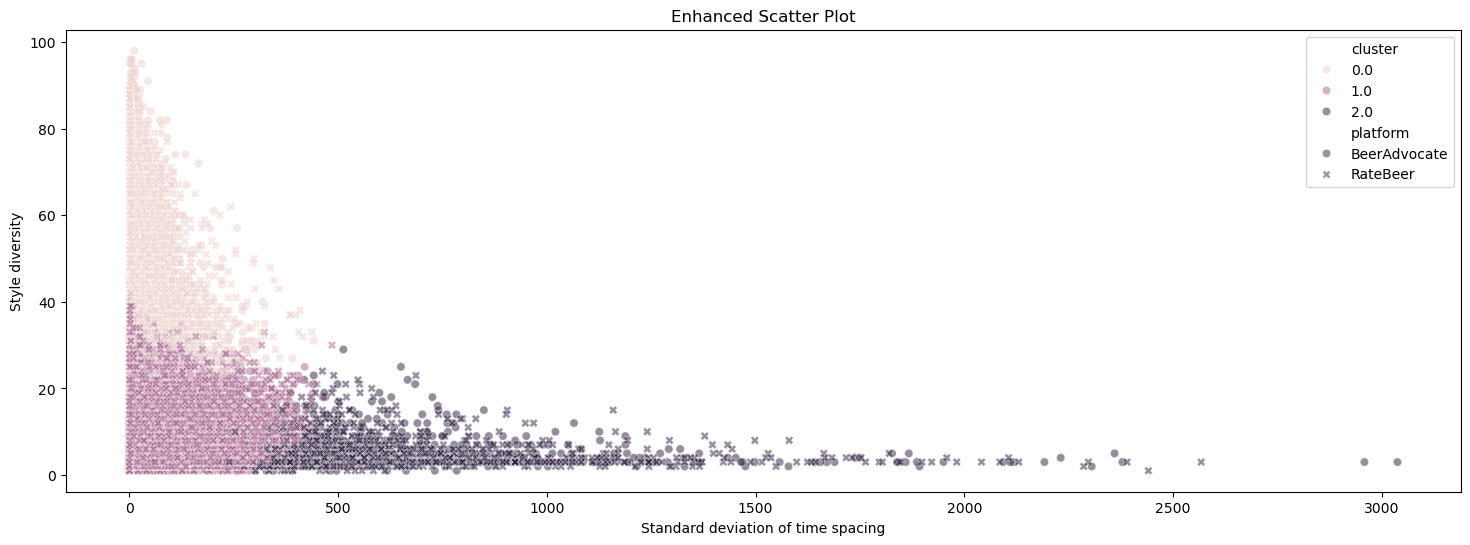

In [28]:
# Scatter plot using seaborn
sns.scatterplot(data=features, x='std_time_spacing', y='style_diversity', hue='cluster', style='platform', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Standard deviation of time spacing')
plt.ylabel('Style diversity')
plt.title('Enhanced Scatter Plot')
plt.show()

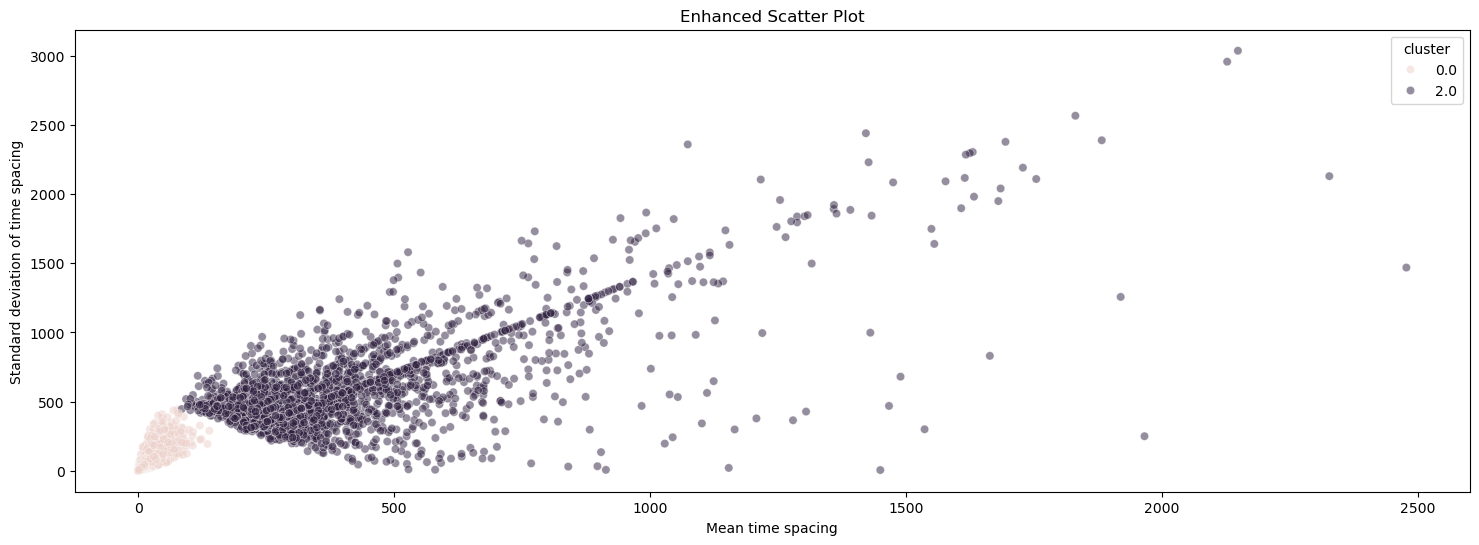

In [29]:
# Scatter plot using seaborn
sns.scatterplot(data=features[features['cluster']!=1], x='mean_time_spacing', y='std_time_spacing', hue='cluster', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Mean time spacing')
plt.ylabel('Standard deviation of time spacing')
plt.title('Enhanced Scatter Plot')
plt.show()

## Analysis

In [38]:
cluster_summary = features.drop(columns='platform').groupby('cluster').mean()
cluster_summary

,total_reviews,usage_duration,style_diversity,predilection_ratio,mean_time_spacing,std_time_spacing
cluster,,,,,,
0.0,787.082943,3312.237124,54.302118,0.117644,9.265115,32.040871
1.0,15.343042,2373.519516,8.439989,0.316513,32.719207,51.908467
2.0,6.320116,3350.288724,5.061958,0.331714,407.190320,579.264233


In [45]:
cluster_summary = features.drop(columns='platform').groupby('cluster').agg(['mean','median','std','min','max'])
cluster_summary

total_reviews                                usage_duration          \
                 mean median          std min    max           mean  median   
cluster                                                                       
0.0        787.082943  235.0  1829.413375  19  43251    3312.237124  3444.0   
1.0         15.343042    7.0    22.959760   3    660    2373.519516  2079.0   
2.0          6.320116    5.0     5.038403   3     42    3350.288724  3414.0   

                                     ... mean_time_spacing              \
                 std    min     max  ...              mean      median   
cluster                              ...                                 
0.0      1439.857917    9.0  7647.0  ...          9.265115    4.958638   
1.0      1431.702080    0.0  6318.0  ...         32.719207   12.250000   
2.0      1225.633584  658.0  6284.0  ...        407.190320  329.700000   

                                    std_time_spacing                          \
                std     min     max             mean      median         std   
cluster                                                                        
0.0       12.255922   0.000   139.0        32.040871   15.718444   45.285004   
1.0       47.432715   0.000   417.5        51.908467   19.166572   72.725294   
2.0      258.045035  85.075  2477.0       579.264233  485.782359  332.709262   

                                
              min          max  
cluster                         
0.0      0.000000   442.132134  
1.0      0.000000   485.314109  
2.0      4.949747  3037.730732  

[3 rows x 30 columns]

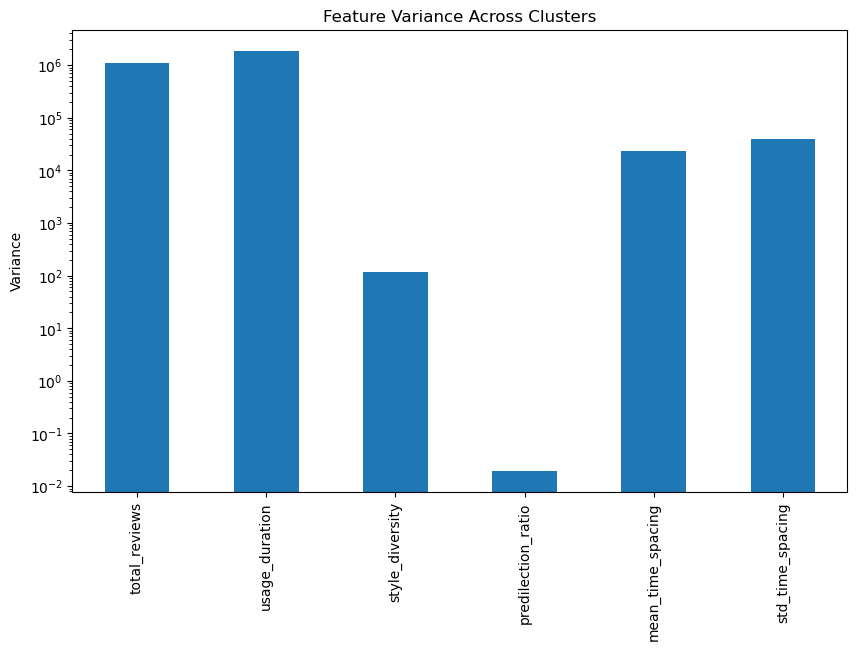

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0.0,8970.0,787.082943,1829.413375,19.0,110.0,235.0,660.0,43251.0
1.0,35535.0,15.343042,22.959760,3.0,4.0,7.0,17.0,660.0
2.0,2421.0,6.320116,5.038403,3.0,3.0,5.0,7.0,42.0


In [39]:
feature_variance = features.drop(columns='platform').groupby('cluster').var().mean()

feature_variance.plot(kind='bar', figsize=(10, 6), title='Feature Variance Across Clusters')
plt.ylabel('Variance')
plt.yscale('log')
plt.show()

features.groupby('cluster')['total_reviews'].describe()

In [40]:
features.groupby(['platform']).size()

platform
BeerAdvocate    31804
RateBeer        70121
dtype: int64

**Analysis** : RateBeer has more reviewers with more than 2 reviews than BeerAdvocate

In [41]:
# How many for each platform in cluster 0, 1 and 2
features.groupby(['platform','cluster']).size()


platform      cluster
BeerAdvocate  0.0         2179
              1.0        10794
              2.0         1172
RateBeer      0.0         6791
              1.0        24741
              2.0         1249
dtype: int64

**Analysis** : RateBeer has more active/experienced users than BeerAdvocate

**Analysis** : The cluster 0 is considered as the more active and thus, corresponding to experienced reviewers. The cluster 2 is considered as the less reviewers.

In [55]:
features_experienced = features[features['cluster']==0]
experienced_users = features_experienced.index
experienced_users

Index(['oline73.371504', 'davolebomb.207412', 'urbancaver.392863',
       'beveritt.73492', 'wagenvolks.40929', 'shanepb.500016',
       'grg1313.288024', 'uclabrewn84.439438', 'sabtos.1081399',
       'masterski.113604',
       ...
       '336887', '3432', '95600', '14181', '170138', '5317', '36352', '33335',
       '9477', '3870'],
      dtype='object', name='user_id', length=8970)

In [56]:
# Export experienced reviewers
experienced_users.to_series().to_csv("exp_user_id.csv", index=False, header=["user_id"])